# DFT (with iceberg cost extension)

## Chase Abram

We implement a discretization of the DFS 1977 trade model with the iceberg cost extension.

In [1]:
# For plotting
using Plots
# For reading in a and b
using DelimitedFiles
using Random

# Setup

In [2]:
# Read in a and b (must make b an N-array instead of Nx1-array)
a_ex = readdlm("DFS1977_example_a.txt")
b_ex = readdlm("DFS1977_example_b.txt")[:,1]

# Setup default L and g, and iceberg g
L_def = [1.0, 1.0]
g_def = 1.0
g_ice = 0.9

0.9

# Simple Plot of $A(z)$ and $B(z;L^*/L)$

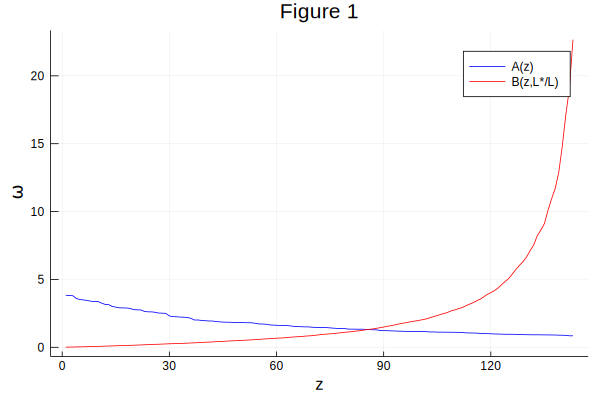

In [3]:
# returns B demand schedule (Equation 10')
function B(b,L)
    vartheta = cumsum(b)
    Lfor = L[1]
    Ldom = L[2]
    return vartheta ./ (1 .- vartheta) * Lfor/Ldom
end

# Plots Figure 1
function DFS1977fig1(a,b,L,cutoff = 0.95)
    
    # Range for z 
    z = LinRange(1, size(a)[1], size(a)[1])

    # Cutoff ratio so plot ignores when B goes to infinity
    cutindex = Int(ceil(cutoff*length(z)))
    
    p = plot(z[1:cutindex],(a[:,1] ./ a[:,2])[1:cutindex],
        title = "Figure 1",
        xlabel = "z",
        ylabel = "\\omega",
        label = "A(z)",
        line = (:blue))
    plot!(z[1:cutindex],B(b,L)[1:cutindex],
        label = "B(z,L*/L)", 
        line = (:red))
    display(p)
end

# Display plot
# DFS1977fig1(a_ex,b_ex,L_def)

In [4]:
# Check data structure of a
function checka(a)
    # Check a dimensions
    if (size(a)[1] <= 2) || (size(a)[2] != 2)
        println("a has incorrect dimensions")
        return false
    end
    
    # Check A > 0
    if minimum(a .> 0) < 1
        println("a is not positive everywhere")
        return false
    end
    
    # Define A = a^*(z)/a(z)
    A = a[:,1] ./ a[:,2]
    
    # Check A' < 0
    if !issorted(A, rev = true)
        println("A is not strictly decreasing")
        return false
    end
    
    return true
end


# Check data structure of b
function checkb(a,b, tol=1e-5)
    
    # Must be same length as a
    if size(a)[1] != length(b)
        println("b wrong length")
        return false
    end
    
    # Must be positive
    if minimum(b .> 0) < 1
        println("b not positive")
        return false
    end
    
    # Must sum to 1 (within tolerance)
    if sum(b) < 1-tol || sum(b) > 1+tol
        println("b does not sum to 1")
        return false
    end
    
    return true
end

# Check that g is a scalar and in (0, 1]
function checkg(g)
    return (length(g) == 1) && (g > 0) && (g <= 1)
end

# Check that L has two positive entries
function checkL(L)
    return (length(L) == 2) && (L[1] > 0) && (L[2] > 0)
end

checkL (generic function with 1 method)

# Solver

I outline the algorithm used below.

1. Check all inputs using above specifications.
2. Discretize the $\omega$ domain $\Omega$ to be the image of $A$. We cannot be more detailed than this without imposing extra assumptions on $A$ for $z$-values other than those given. For simplicty in indexing, we let $Z = \{1, \ldots, N\}$, where $N$ is the length of b.
3. Given $g$, find approximations for $\bar{z}$ and $\bar{z}^*$ by solving
$$ \bar{z}(\omega \cdot g) = \arg\min_{z \in Z} |A(z) - \omega \cdot g| $$
$$ \bar{z}^*(\omega / g) = \arg\min_{z \in Z} |A(z) - \omega / g| $$
4. Define $\lambda, \lambda^*$, and $\varphi$:
$$ \lambda(\omega \cdot g) = \sum_{z=1}^{\bar{z}(\omega \cdot g)} b(z) $$
$$ \lambda(\omega / g) = \sum_{z=1}^{\bar{z}^*(\omega) / g} b(z) $$
$$ \varphi(\omega; L^*/L, g) = \frac{1 - \lambda^*(\omega / g)}{1 - \lambda(\omega \cdot g)} \frac{L^*}{L}$$
5. Find equilibrium 

$$ \bar{\omega} \equiv \arg\min_{\omega \in \Omega} |\omega - \varphi(\omega; L^*/L, g)| $$
6. Use $\bar{\omega}$ to find and return other relevant equilibrium variables.


In [5]:
# Finds the eq of the DFS model, allowing for iceberg costs
function DFS1977solver(a::Array{Float64,2}, b::Array{Float64,1}, 
        L::Array{Float64,1}, g::Float64)
    
    # Check a (see above function)
    if !checka(a)
        error("a does not meet requirements")
    end
    
    # Check b (see above function)
    if !checkb(a,b)
        error("b does not meet requirements")
    end
    
    # Check g (see above function)
    if !checkg(g)
        error("g does not meet requirements")
    end
    
    # Check L (see above function)
    if !checkL(L)
        error("L does not meet requirements")
    end
    
    # Define A = a^*(z)/a(z)
    A = a[:,1] ./ a[:,2]
    
    # Discretized omega domain (cannot be more detailed than A's discretization)
    w_list = sort(A)
    
    # Find z_bar by roughly inverting A (eq. 21)
    z_bar = [findmin(abs.(A - ones(length(A)).* w .* g))[2] for w in w_list]
    
    # Find z_bar_star by roughly inverting A (eq. 21)
    z_bar_star = [findmin(abs.(A - ones(length(A)).* w ./ g))[2] for w in w_list]
    
    # Find lambda (eq. 20)
    lambda = [sum(b[1:zi]) for zi in z_bar]
    
    # Find lambda_star (eq. 20)
    lambda_star = 1 .- [sum(b[1:zi]) for zi in z_bar_star]
    
    # Find varphi (eq. 19')
    varphi = (1 .- lambda_star) ./ (1 .- lambda) .* (L[1]/L[2])
    
    # Find the equilibrium
    # Find index where varphi(omega) = omega
    eq_cross = findmin(abs.(varphi .- w_list))[2]
    
    # Find that omega
    eq_omega = w_list[eq_cross]
    
    # Find corresponding z_bar and z_bar_star (eq. 21)
    eq_z_bar = findmin(abs.(A .- ones(length(A)) .* eq_omega .* g))[2]
    eq_z_bar_star = findmin(abs.(A .- ones(length(A)) .* eq_omega ./ g))[2]
    
    return Int(eq_z_bar), A[eq_z_bar], Int(eq_z_bar_star), A[eq_z_bar_star], eq_omega
end

DFS1977solver (generic function with 1 method)

# Error Checking

In [6]:
# We check that our function errors our properly

# Use example a and b and default L and g
a = deepcopy(a_ex)
b = b_ex
L = L_def
g = g_def

# A = a[:,1] ./ a[:,2]
# println(A)

# a shape error
# a = [0.1 1.1; 2.1 0.1]
# DFS1977solver(a,b,L,g)

# a sign error
# a = a_ex .* -1
# DFS1977solver(a,b,L,g)

# A' < 0 error
# a[:,2] = sort(a[:,2], rev = true)
# DFS1977solver(a,b,L,g)
# DFS1977fig1(a,b,L)

# b shape error
# a = a_ex
# b = [0.1, 0.3]
# DFS1977solver(a,b,L,g)

# b sign error
# b = a_ex[:,1] .* -1
# DFS1977solver(a,b,L,g)

# b proper pmf error
# b = deepcopy(b_ex)
# b[1] += 0.01
# DFS1977solver(a,b,L,g)

# g domain error
# b = b_ex
# g = -1.0
# DFS1977solver(a,b,L,g)

# Baseline
# println("g=1: ", DFS1977solver(a,b,L,g_def))

# 10% iceberg loss
# println("g=0.9: ", DFS1977solver(a,b,L,g_ice))

g=1: (86, 1.3061186652154024, 86, 1.3061186652154024, 1.3061186652154024)
g=0.9: (94, 1.1892803426645433, 72, 1.4650371882146167, 1.318628976552968)


# Welfare and Gains from Trade

From slide 10 of the week 2 slide deck, we have domestic welfare (discretized)

$$ \ln(U/L) \approx \ln(w) - \sum_{z=1}^N b(z) \ln (p(z)) $$

where $p(z) = w a(z)$ everywhere under autarky, but under trade $p(z) = w a(z)$ when producing at home, and $p(z) = (1/g)w^* a^*(z)$ when importing from foreign. Then we can find the gains from trade by taking the difference between trade welfare and autarky welfare, so (hiding the exogenous variables giving the equilibrium)

$$ GFT = - \sum_{z = \bar{z}}^Z b(z) \ln(A(z) / (g \omega)) $$

Analogous expressions hold for foreign.

In [7]:
# Returns welfare in trade equilibrium for domestic and foreign
function welfare(a::Array{Float64,2}, b::Array{Float64,1}, 
        L::Array{Float64,1}, g::Float64)
    
    # Solve eq.
    z_bar, A_bar, z_bar_star, A_bar_star, omega_bar = DFS1977solver(a,b,L,g)
    
    # Labeling helps readability of welfare calculation
    a_for = a[:,1]
    a_dom = a[:,2]
    
    # Calculate foreign and domestic welfare (w = 1 included for clarity)
    for_wel = log(1/omega_bar) - sum((b .* log.(1/g .* a_dom))[1:z_bar_star]) - sum((b .* log.(1/omega_bar .* a_for))[z_bar_star+1:end])
    dom_wel = log(1) - sum((b .* log.(1 .* a_dom))[1:z_bar-1]) - sum((b .* log.(1/(g * omega_bar) .* a_for))[z_bar:end])
    
    return [dom_wel, for_wel]
end

# Returns gains from trade (welfare trade minus welfare autarky)
function welfareGFT(a::Array{Float64,2}, b::Array{Float64,1}, 
        L::Array{Float64,1}, g::Float64)
    
    # Solve trade eq.
    z_bar, A_bar, z_bar_star, A_bar_star, omega_bar = DFS1977solver(a,b,L,g)
    
    # Only need A for diff calc
    A = a[:,1]./a[:,2]
    
    # Calculate gains from trade, via integral equation on slide 10, week 2)
    dom_gain =  -sum((b .* log.(1/(g * omega_bar) .* A))[z_bar:end])
    for_gain = -sum((b .* log.(omega_bar/g .* (1 ./ A)))[1:z_bar_star])
    
    return [dom_gain, for_gain]
end

welfareGFT (generic function with 1 method)

## Iceberg Experiment

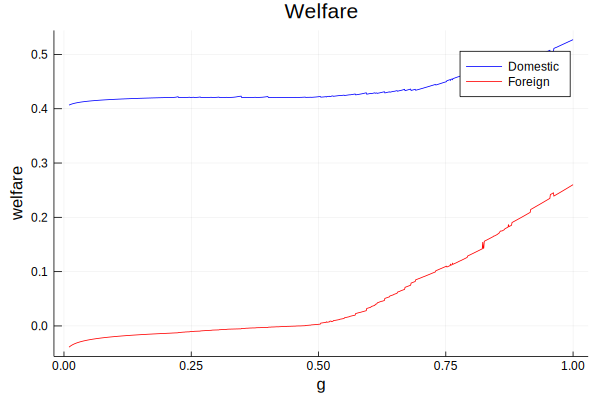

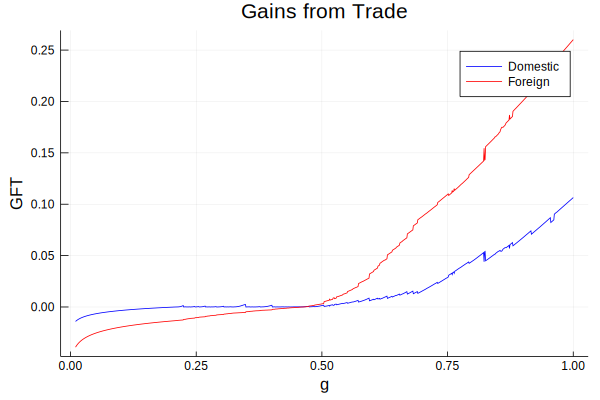

In [8]:
# How do welfare and gains from trade change as we vary  g?
gs = LinRange(0.01,1,1000)
dom_wels = [welfare(a,b,L,g)[1] for g in gs]
for_wels = [welfare(a,b,L,g)[2] for g in gs]
pw_ice = plot(gs,dom_wels ,
        title = "Welfare",
        xlabel = "g",
        ylabel = "welfare",
        label = "Domestic",
        line = (:blue))
plot!(gs,for_wels, label = "Foreign", line = (:red))
# display(pw_ice)

dom_gains = [welfareGFT(a,b,L,g)[1] for g in gs]
for_gains = [welfareGFT(a,b,L,g)[2] for g in gs]
pg_ice = plot(gs,dom_gains ,
        title = "Gains from Trade",
        xlabel = "g",
        ylabel = "GFT",
        label = "Domestic",
        line = (:blue))
plot!(gs,for_gains, label = "Foreign", line = (:red))
# display(pg_ice)

## Foreign Tech Improvement Experiment

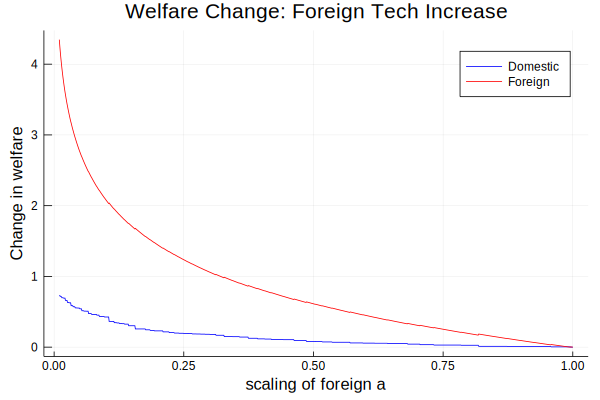

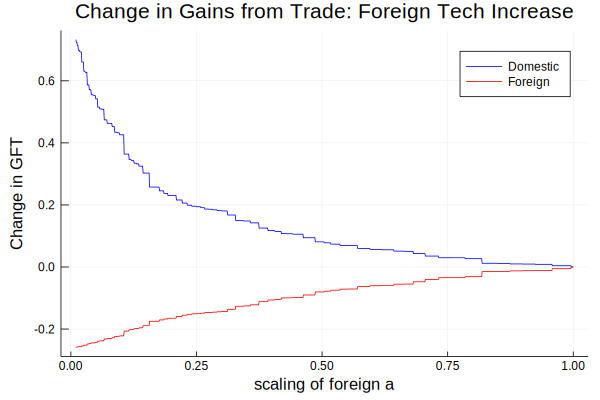

In [9]:
# How do welfare and gains from trade change as we vary the scaling of foreign a?
scales = LinRange(0.01,1,1000)
dom_wels = zeros(length(scales))
for_wels = zeros(length(scales))
dom_gains = zeros(length(scales))
for_gains = zeros(length(scales))
for i in 1:length(scales)
    a_tech_scale = deepcopy(a_ex)
    a_tech_scale[:,1] = scales[i]*a_tech_scale[:,1]
    dom_wels[i], for_wels[i] = welfare(a_tech_scale,b,L,g) .- welfare(a,b,L,g)
    dom_gains[i], for_gains[i] = welfareGFT(a_tech_scale,b,L,g) .- welfareGFT(a,b,L,g)
end

pw_tech = plot(scales, dom_wels,
        title = "Welfare Change: Foreign Tech Increase",
        xlabel = "scaling of foreign a",
        ylabel = "Change in welfare",
        label = "Domestic",
        line = (:blue))
plot!(scales,for_wels, label = "Foreign", line = (:red))
# display(pw_tech)

pg_tech = plot(scales,dom_gains ,
        title = "Change in Gains from Trade: Foreign Tech Increase",
        xlabel = "scaling of foreign a",
        ylabel = "Change in GFT",
        label = "Domestic",
        line = (:blue))
plot!(scales,for_gains, label = "Foreign", line = (:red))
# display(pg_tech)

# Decoupling Volume and GFT
What is the relationship between the volume of trade and each country's gains from trade in this model? Use your solver to produce an example of different equilibria (with the same L, L*, and g<1) that exhibit the same volume of trade and different gains from trade. If you also hold fixed the b schedule, can you produce such an example? Why or why not? What can be said about the magnitude of the gains from trade in this model if we observe the equilibrium volume of trade and do not observe autarky prices?

Volume of trade can be summarized by knowing equilibrium $\bar{z}$ and $\bar{z}^*$, whereas gains from trade are summarized in the integral/sum above. Consider the equilibrium condition fully in terms of given forms and parameters:

$$ \bar{\omega} = \frac{1 - \int_{A^{-1}(\bar{\omega}/g)}^1 b(z) dz}{1 - \int_{0}^{A^{-1}(\bar{\omega} \cdot g)} b(z) dz} \frac{L^*}{L}$$

From this condition, we can easily see that if we hold $b, L, L^*$ and $g$ constant, there are any number of $A$ which will yield the same $\bar{\omega}$ since we merely need $A' < 0$ and for $A^{-1}$ to hit the same two values in the integral limits. Generally, though, different $A$ will yield different gains from trade.

A simple way to display this dynamic is to "twist" $A$, such as by scaling up $A$ before $\bar{z}^*$, scaling down $A$ after $\bar{z}$, and linearly interpolating $A$ between $\bar{z}$ and $\bar{z}^*$. This "twisting" will increase the gains from trade, while preserving equilibrium $\bar{\omega}$, $\bar{z}$, and $\bar{z}^*$. (Note: $\bar{\omega}$ will change slightly below due to the discretization process being changed, since we change the image of $A$. This is an artifict of the discretization.)

We now employ this logic.

z_bar: 94 z_bar_tw: 94
z_bar_star: 72 z_bar_star_tw: 72
A_bar: 1.1892803426645433 A_bar_tw: 1.1892803426645433
A_bar_star: 1.4650371882146167 A_bar_star_tw: 1.4650371882146167
omega_bar: 1.318628976552968 omega_bar_tw: 1.3128345866284374
GFT: 

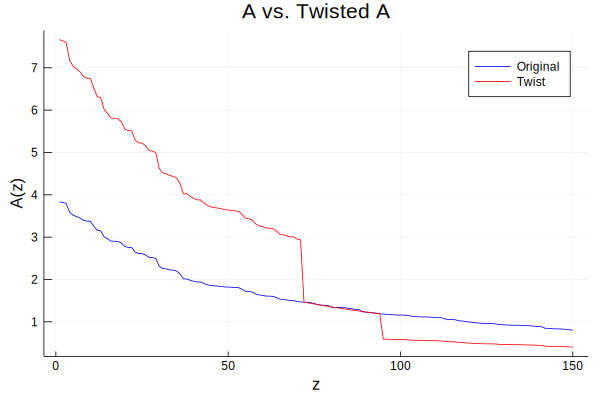

[0.06748227928319099, 0.20069852840922434] GFT_tw: [0.3220733990540474, 0.5293545408607343]


In [10]:
# We build an example where equilibrium volume of trade relative wage, 
# b, L, and g are the same, but gains from trade differ
# Original
a = a_ex
b = b_ex
L = L_def
g = g_ice
z = LinRange(1,length(b),length(b))

# Twisting parameter
twist = 0.5

# Solve trade eq.
z_bar, A_bar, z_bar_star, A_bar_star, omega_bar = DFS1977solver(a,b,L,g)

# Create twisted A (note that we are using calculated eq.)
a_tw = deepcopy(a)
for zi in 1:length(z)
    # twist up
    if zi < z_bar_star
        a_tw[zi,2] = a[zi,2]*twist
    # interpolate
    elseif zi > z_bar_star && zi < z_bar
        split = (zi - z_bar_star)/(z_bar - z_bar_star)
        a_tw[zi,2] = (1 - split) * a[z_bar_star,2] + split * a[z_bar,2]
    # twist down
    elseif zi > z_bar
        a_tw[zi,2] = a[zi,2]/twist    
    end
end


# Calculate twisted eq.
z_bar_tw, A_bar_tw, z_bar_star_tw, A_bar_star_tw, omega_bar_tw = DFS1977solver(a_tw,b,L,g)
# Check that everything matches, except for GFT
# println("z_bar: ", z_bar, " z_bar_tw: ", z_bar_tw)
# println("z_bar_star: ", z_bar_star, " z_bar_star_tw: ", z_bar_star_tw)
# println("A_bar: ", A_bar, " A_bar_tw: ", A_bar_tw)
# println("A_bar_star: ", A_bar_star, " A_bar_star_tw: ", A_bar_star_tw)
# println("omega_bar: ", omega_bar, " omega_bar_tw: ", omega_bar_tw)
# println("GFT: ", welfareGFT(a,b,L,g), " GFT_tw: ", welfareGFT(a_tw,b,L,g))


pt = plot(z,a[:,1]./a[:,2],
        title = "A vs. Twisted A",
        xlabel = "z",
        ylabel = "A(z)",
        label = "Original",
        line = (:blue))
plot!(z,a_tw[:,1]./a_tw[:,2], label = "Twist", line = (:red))
# display(pt)

# Follow-up discussion

We above showed that, even holding fixed $b$, we were able to preserve equilibrium trade volume and relative wages, but change gains from trade. Therefore we may conclude that, if we are only given volume and relative wages under trade (no autarky information) we have no way of discerning gains from trade, since there are a continuum of possible $A$ that yield any observed equilibrium. To be precise, the above notion may be generalized, and we can say that for any given equilibrium $E$, we may only identify $A$ such that

$$ A \in \mathcal{A}(E) \equiv \{A(\bar{z}_E) = \omega \cdot g, A(\bar{z}^*_E) = \omega /g, A'(z) < 0\}$$

Since we cannot identify $A$, we cannot identify gains from trade, which is the integral equation above that depends on $A$ more than just through the two value conditions required to generate a given equilibrium. The reason we find this behavior is that $A$ only plays into equilibrium determination through the "two intersections" that determine $\bar{z}$ and $\bar{z}^*$, and otherwise the monotonicity alone is all that matters. So the "shape" of $A$ off of the two switch points is irrelevant for determining trade, which is a 1-0 decision, but is relevant for determining GFT, which is may take any value, depending on "how much" the trade improves welfare.

In fact, the above argument can actually be strengthened, since I demanded that $\bar{z}$ and $\bar{z}^*$ not change, but all that is needed for trade volume to be preserved is that $V \equiv (\bar{z}^* - 0) + (1 - \bar{z})$ is preserved. Therefore if we also freed $\bar{z}$ and $\bar{z}^*$ and only constrained $V$ to be held constant, we would find even more $A$ which would be consistent with observations.

# Robustness Checks
## From juliabox example

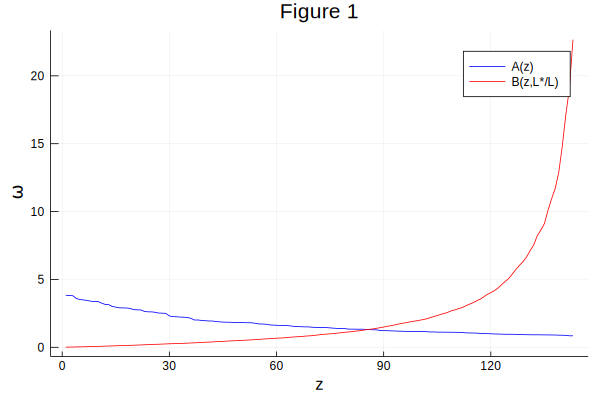

Solution: z_bar_star = 86 z_bar = 86 omega_bar = 1.3061186652154024
Solution: z_bar_star = 72 z_bar = 94 omega_bar = 1.318628976552968


In [11]:
Random.seed!(1234) # set seed
N = 150; # no. of varieties
a =hcat(ones(N,1),0.25*ones(N,1) + rand(N,1));
a[:,2] = sort(a[:,2])
b = 0.5*rand(N) + 0.5*ones(N)
b = b / sum(b)
L = ones(2)
g = 1.0;
cutoff = 0.95

DFS1977fig1(a,b,L)

z_bar, A_bar,z_bar_star,A_bar_star,omega_bar = DFS1977solver(a,b,L,g)
println("Solution: z_bar_star = ", z_bar_star, " z_bar = ", z_bar, " omega_bar = ", omega_bar)
z_bar, A_bar,z_bar_star,A_bar_star,omega_bar = DFS1977solver(a,b,L,0.9)
println("Solution: z_bar_star = ", z_bar_star, " z_bar = ", z_bar, " omega_bar = ", omega_bar)

# Bigger data set

In [12]:
N = 10000
z = LinRange(1, N, N)
z = 6
a = ones(N,2)
a[:,2] = sort(0.1 .+ rand(N))
g = 0.9

b = rand(N)
b /= sum(b)

# Cutoff ratio so plot ignores when B goes to infinity
cutoff = 0.95
cutindex = Int(ceil(cutoff*N))

# Solve trade eq.
z_bar, A_bar, z_bar_star, A_bar_star, omega_bar = DFS1977solver(a,b,L,g)
# println("z_bar: ", z_bar)
# println("z_bar_star: ", z_bar_star)
# println("A_bar: ", A_bar)
# println("A_bar_star: ", A_bar_star)
# println("omega_bar: ", omega_bar)
# println("GFT: ", welfareGFT(a,b,L,g))

z_bar: 6547
z_bar_star: 5071
A_bar: 1.3224622711403526
A_bar_star: 1.6328633908217174
omega_bar: 1.4696225727348824
GFT: [0.06953894813258316, 0.3241243750696454]


In [13]:
# The below section was used for checking results against peers

# a = a_ex
# a_tech = deepcopy(a)
# a_tech[:,1] = a_tech[:,1] .- 0.5
# b = b_ex
# L = L_def
# g = 0.9

# println("GFT: ", welfareGFT(a,b,L,g))
# println("welfare trade: ", welfare(a,b,L,g))
# println("welfare aut: ", welfare(a,b,L,g) - welfareGFT(a,b,L,g))

# println("GFT: ", welfareGFT(a_tech,b,L,g))
# println("welfare trade: ", welfare(a_tech,b,L,g))
# println("welfare aut: ", welfare(a_tech,b,L,g) - welfareGFT(a_tech,b,L,g))

# N = 1000
# a = ones(N,2)
# Random.seed!(1234) # set seed
# a[:,2] = sort(0.1 .+ rand(N))
# b = rand(N)
# b /= sum(b)
# println(DFS1977solver(a,b,L,g))

# Random.seed!(1235) # set seed
# a[:,2] = sort(0.1 .+ rand(N))
# b = rand(N)
# b /= sum(b)
# println(DFS1977solver(a,b,L,g))

# Random.seed!(1236) # set seed
# a[:,2] = sort(0.1 .+ rand(N))
# b = rand(N)
# b /= sum(b)
# println(DFS1977solver(a,b,L,g))